# Laboratorio: Preparazione Dati e Alberi di Regressione

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Setup

Importiamo le librerie di uso comune

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

Definiamo la seguente funzione di supporto per scaricare i file di dati necessari

In [4]:
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

Installeremo e testeremo altre librerie nella parte finale dell'esercitazione

## Caso di studio: Predizione vendite

I negozi sono interessati a prevedere quanto più accuratamente possibile le vendite giornaliere per ottimizzare le scorte di magazzino, il personale da impiegare, ecc.

Le vendite sono influenzate da diversi fattori, quali giorno della settimana, festività, promozioni, ...

In questo caso di studio riprendiamo il dataset dellle vendite registrate da più di 1.000 negozi della catena europea Rossmann, oggetto di una [competizione su Kaggle](https://www.kaggle.com/c/rossmann-store-sales)

### Dataset

Della competition utilizziamo i file con i dati delle vendite dal 2013 a metà 2015 _(nome originale: `train.csv`)_ e il file con le informazioni dettagliate sui negozi _(nome originale: `store.csv`)_

In [5]:
download("rossmann-train.csv.gz", "https://github.com/datascienceunibo/dialab2024/raw/main/Regressione_con_Alberi/rossmann-train.csv.gz")
download("rossmann-stores.csv", "https://github.com/datascienceunibo/dialab2024/raw/main/Preprocessing_con_pandas/rossmann-stores.csv")

Carichiamo il file `rossmann-train.csv.gz` specificando alcune opzioni

  - con `parse_dates=["Date"]` ci accertiamo che la colonna della data sia trattata come tale
  - `StateHoliday` è una variabile categorica che per valori possibili ha sia numeri (0) che stringhe (`a`, `b`, `c`), definiamo preventivamente il suo `dtype` per farla interpretare correttamente
  - il file è compresso col formato GZIP, lo esplicitiamo con `compression="gzip"` _(in questo caso non necessario in quanto dedotto dall'estensione)_

In [6]:
data_sales = pd.read_csv(
    "rossmann-train.csv.gz",
    parse_dates=["Date"],
    dtype={"StateHoliday": "category"},
    compression="gzip",
)

In [7]:
data_sales

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


Ciascuna riga del frame contiene i dati relativi ad un singolo negozio in una singola data.

Riportiamo sotto il significato delle colonne dalla pagina della competizione.

- `Store`: identificatore del negozio, un intero da 1 a 1.115
- `DayOfWeek`: giorno della settimana (1 = lunedì, 2 = martedì, ..., 7 = domenica)
- `Date`: data a cui si riferiscono i dati, nel formato standard ISO `YYYY-MM-DD`
- `Sales`: ricavo totale del negozio nella giornata _(valuta non indicata, assumeremo in Euro)_
- `Customers`: numero di clienti del negozio nella giornata
- `Open`: indica se il negozio era aperto (1 = aperto, 0 = chiuso)
- `Promo`: indica se una promozione era in corso nel negozio (1 = in corso, 0 = non in corso)
- `StateHoliday`: indica se nella data c'era una festività e di quale tipo (`a` = festa nazionale, `b` = Pasqua, `c` = Natale, 0 = nessuna festività)
- `SchoolHoliday`: indica se nella data le scuole erano chiuse (1 = chiuse, 0 = aperte)

Il nostro obiettivo consiste nell'addestrare un modello a **prevedere la variabile `Sales`** sulla base delle altre informazioni disponibili.

Possiamo ipotizzare e verificare che il ricavo totale `Sales` è strettamente proporzionale al numero di clienti `Customers`.

_(usiamo il metodo `sample` per selezionare un numero dato di campioni casuali per creare il grafico con più efficienza)_

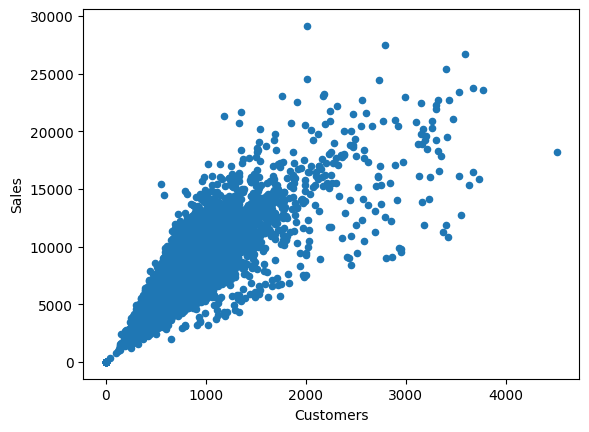

In [8]:
data_sales.sample(10000, random_state=42).plot.scatter("Customers", "Sales");

Non possiamo però usare la variabile `Customers` nella predizione, in quanto così come `Sales` **non è un'informazione nota a priori**.

Quando si utilizza un dataset per addestrare un modello di predizione, verificare sempre attentamente quali informazioni è lecito utilizzare!

### Esercizio 1: Caricamento e preprocessamento dati

- **(1a)** Creare un frame `data_open` selezionando le sole righe di `data_sales` dove `Open` è 1 (il negozio era aperto) e scartando quindi la colonna `Open`
- **(1b)** Caricare in un DataFrame il file `rossmann-stores.csv` usando le opzioni di default
- **(1c)** Creare un frame `data` che combina il frame caricato con `data_sales` sulla colonna `Store`, facendo in modo che ad ogni riga di `data_sales` vengano aggiunte le informazioni complete sul negozio

In [9]:
#1a
data_open = data_sales.loc[data_sales["Open"] == 1].drop(columns=["Open"])

In [10]:
#1b
data_stores = pd.read_csv("rossmann-stores.csv")

In [11]:
#1c
data = pd.merge(data_open, data_stores, left_on=["Store"], right_on=["Store"])
# abbreviabile in:
# data_merged = pd.merge(data_open, data_stores, on=["Store"])

## Generazione di variabili predittive

Abbiamo integrato nei dati delle vendite delle informazioni sui singoli negozi, ma che sono indipendenti dalle date specifiche.

Per avere dati più precisi da utilizzare per la predizione, usiamo i dati presenti per creare nuove variabili che riflettono invece informazioni specifiche sulla data corrente.

Consideriamo ad esempio le seguenti variabili che danno informazioni sulla "Promo2", una promozione continuativa offerta da alcuni negozi:

- `Promo2` indica se il negozio prende parte alla promozione (0 = no, 1 = sì)
- `Promo2SinceWeek` e `Promo2SinceYear`: numero di settimana e anno a partire dai quali il negozio ha iniziato a prendere parte alla Promo2
- `PromoInterval`: mesi dell'anno in cui nel negozio è attiva la Promo2

Vogliamo creare una variabile `Promo2Active` che indica per ogni riga se la Promo2 era attiva nella data specifica indicata dalla riga, tenendo conto di quando è iniziata e in quali mesi è attiva.

Iniziamo determinando in quali casi il negozio aveva iniziato a prendere parte alla Promo2, secondo quanto indicato dalle colonne `Promo2SinceWeek` e `Promo2SinceYear`.

Presa una singola riga, possiamo verificare se la Promo2 era già iniziata verificando se la data è in un anno successivo a `Promo2SinceYear` oppure se è lo stesso anno e il numero di settimana è uguale o successivo a `Promo2SinceWeek`. Nei casi in cui la Promo2 non è applicata le due colonne hanno valore `NaN` e il confronto restituisce `False`.

Creiamo una serie `promo2_started` che indica in quali righe si verifica questa condizione. _(`isocalendar().week` serve ad estrarre la settimana dell'anno, in versioni vecchie di pandas va usato `weekofyear`)_

In [12]:
promo2_started = (
    (data["Date"].dt.year > data["Promo2SinceYear"])
    | (
        (data["Date"].dt.year == data["Promo2SinceYear"])
        & (data["Date"].dt.isocalendar().week >= data["Promo2SinceWeek"])
    )
)

Dobbiamo ora determinare per ciascuna riga se la data corrispondente è in un mese in cui la promozione è attiva nel negozio.

`PromoInterval` ha un insieme limitato di valori possibili, che sono i seguenti:

In [13]:
data["PromoInterval"].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

Per facilitare l'elaborazione, sostituiamo tali stringhe con liste di numeri dei mesi. Per farlo possiamo usare il metodo `map` visto in precedenza che sostituisce i valori di una serie con altri in base ad un dizionario dato.

Definiamo un dizionario che associa ad ogni valore possibile la lista di numeri risultante.

In [14]:
months_map = {
    np.nan: [],
    "Jan,Apr,Jul,Oct":  [1, 4, 7, 10],
    "Feb,May,Aug,Nov":  [2, 5, 8, 11],
    "Mar,Jun,Sept,Dec": [3, 6, 9, 12],
}

Creiamo quindi una colonna `Promo2Months` contenente queste liste.

In [15]:
data["Promo2Months"] = data["PromoInterval"].map(months_map)

In una singola riga, per verificare se il mese della data è incluso nella lista di mesi, possiamo usare l'operatore `in`.

Creiamo una funzione che, data una riga del dataset, verifica questa condizione _(`row["Date"]` è una singola data e non una serie, per questo si usa `month` invece di `dt.month`)_

In [16]:
def check_promo2_month(row):
    return row["Date"].month in row["Promo2Months"]

Ad esempio per verificare la condizione sulla prima riga del dataset:

In [17]:
check_promo2_month(data.iloc[0])

False

Per applicare questa funzione a tutte le righe del dataset possiamo usare il metodo `apply` del DataFrame

- come primo parametro viene indicata una funzione che accetta una serie (una riga del dataset) e restituisce un valore
- specificando `axis=1` indichiamo di applicare la funzione a ciascuna riga (di default è applicata a ciascuna colonna)
- il risultato è una serie le cui etichette sono quelle delle righe e il cui valore è il risultato dato dalla funzione per ciascuna riga

L'uso di `apply` è generalmente più efficiente dell'uso ad es. di un ciclo for, ma meno efficiente delle operazioni vettoriali usate sopra. Si usa in genere quando si vogliono compiere elaborazioni non banali che non si riescono ad eseguire con i soli operatori e metodi vettoriali.

In [18]:
is_promo2_month = data.apply(check_promo2_month, axis=1)

Aggiungiamo infine al dataset una variabile `Promo2Active` che indica per ogni riga se la Promo2 era già iniziata E se era attiva in quel mese.

In [19]:
data["Promo2Active"] = promo2_started & is_promo2_month

### Esercizio 2: Estrazione variabili su concorrenza

Le informazioni sulla concorrenza sono date delle seguenti colonne:

- `CompetitionDistance`: distanza in metri dal punto vendita concorrente più vicino
- `CompetitionOpenSinceMonth` e `CompetitionOpenSinceYear`: mese e anno in cui il punto vendita concorrente più vicino è stato aperto

- **(2a)** Aggiungere al dataset una colonna `CompetitionOpen` che indica se l'eventuale punto vendita concorrente era aperto nella data specifica; nei casi in cui una qualsiasi delle colonne `CompetitionOpenSince*` è `NaN` restituire `True` (si ipotizza che il punto vendita concorrente abbia aperto prima di Rossmann)
- **(2b)** Estrarre il valore massimo di `CompetitionDistance` e inserirlo al posto dei valori `NaN` nella stessa colonna

In [41]:
#2a
data["CompetitionOpen"] = (data["CompetitionOpenSinceYear"].isna()
    | (data["Date"].dt.year > data["CompetitionOpenSinceYear"])
    | ((data["Date"].dt.year == data["CompetitionOpenSinceYear"])
        & (data["Date"].dt.month >= data["CompetitionOpenSinceMonth"])
    )
)

In [42]:
#2b
data.loc[data["CompetitionDistance"].isna(), "CompetitionDistance"] = data["CompetitionDistance"].max()
# oppure: data["CompetitionDistance"] = data["CompetitionDistance"].fillna(data["CompetitionDistance"].max())

## Preparazione dei dati per i modelli di predizione

Per separare i dati in training e validation set, definiamo una data limite per cui tutti i dati fino ad essa costituiscono il training set e tutti quelli successivi costituiscono il validation set.

In [43]:
train_test_split_date = "2015-06-19"
data_train = data[data["Date"] <= train_test_split_date]
data_val = data[data["Date"] > train_test_split_date]

Definiamo le serie `y_*` con i valori da predire di `Sales` per training e validation set.

In [44]:
y_train = data_train["Sales"]
y_val = data_val["Sales"]

Per la predizione utilizzeremo quasi tutte le altre colonne

Molte variabili hanno valori numerici, ma di diversa natura:

  1. alcune variabili (es. `CompetitionDistance`) esprimono effettivamente una quantità o una grandezza (sono di tipo "intervallo" o "ratio")
  2. altre variabili (es. `SchoolHoliday`) sono binarie, valgono 1 dove una condizione è verificata e 0 dove non si verifica; in questo insieme possiamo includere le variabili di tipo booleano, convertite in automatico in binarie ove necessario
  3. altre variabili (es. `StoreType`) esprimono dei "codici", i numeri servono solamente da identificatori univoci (sono di tipo "nominale")

Creiamo tre liste con i nomi delle variabili che vogliamo usare per la predizione, suddivise nei rispettivi gruppi.

In [45]:
numeric_vars = ["CompetitionDistance"]
binary_vars = ["Promo", "SchoolHoliday", "Promo2Active", "CompetitionOpen"]
categorical_vars = ["StateHoliday", "StoreType", "Assortment"]

I metodi di regressione visti finora funzionano con variabili predittive numeriche: di queste viene ad es. calcolata una combinazione lineare secondo i coefficienti appresi dal modello

Questi modelli **non funzionano** in presenza di variabili categoriche: le variabili categoriche sono spesso codificate in modo non numerico (es. strighe): se si provasse ad addestrare un modello di regressione su di esse avremmo un errore

Anche se codificate numericamente, gli algoritmi dedurrebbero erroneamente similarità tra categorie con numeri vicini: ad es. si dedurrebbe che lo `Store` 1 è più simile al 2 che al 900, mentre in realtà ognuno può avere un peso diverso e indipendente dagli altri nella predizione.

### Esercizio 3: Regressione sulle sole variabili numeriche

- **(3a)** Definire `X_train_num` e `X_val_num` come proiezioni dei frame `X_train` e `X_val` contenenti le soli variabili numeriche e binarie del dataset
  - usare `+` per concatenare le due liste di variabili
- **(3b)** Addestrare un modello di regressione Ridge con $\alpha=1$ (default) su `X_train_num` e verificarne l'accuratezza su `X_val_num`
- **(3c)** Addestrare e verificare lo stesso modello sugli stessi dati, ma utilizzando una pipeline per standardizzare i dati

In [40]:
# import necessari
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [46]:
#3a
X_train_num = data_train[numeric_vars + binary_vars]
X_val_num = data_val[numeric_vars + binary_vars]

In [47]:
#3b
model = Ridge()
model.fit(X_train_num, y_train)
model.score(X_val_num, y_val)

0.17431386825210549

In [48]:
#3c
model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", Ridge())
])
model.fit(X_train_num, y_train)
model.score(X_val_num, y_val)

0.17431393899442282

## Trattamento delle variabili categoriche: one-hot encoding

Come si possono utilizzare le variabili categoriche in modelli di regressione?

La soluzione tipica consiste nel convertire le variabili categoriche in numeriche.

Data una variabile categorica X con N valori possibili $a, b, c, \ldots$, il _one-hot encoding_ consiste nel convertirla in N variabili numeriche binarie $X_a, X_b, X_c, \ldots$. Ciascuna variabile $X_v$ vale 1 nei casi in cui $X = v$ e 0 negli altri casi.

Ogni valore di X è in pratica convertito ad un vettore in $\mathbf{R}^N$ con un elemento a 1 e gli altri a 0

- $a \rightarrow [1,0,0,\ldots]$
- $b \rightarrow [0,1,0,\ldots]$
- $c \rightarrow [0,0,1,\ldots]$
- ...

scikit-learn fornisce un filtro `OneHotEncoder` per effettuare questa operazione su tutte le variabili di un dataset

Analizziamone il funzionamento su una variabile binaria e una categorica del dataset

In [26]:
X_sample = data_train[["SchoolHoliday", "StateHoliday"]]
X_sample.head(5)

,SchoolHoliday,StateHoliday
40282,0,0
40283,0,0
40284,0,0
40285,0,0
40286,0,0


I valori possibili di queste variabili sono:

In [27]:
X_sample["SchoolHoliday"].unique()

array([0, 1], dtype=int64)

In [28]:
X_sample["StateHoliday"].unique()

['0', 'a', 'b', 'c']
Categories (4, object): ['0', 'a', 'b', 'c']

Creiamo un'istanza del filtro specificandone i parametri

Normalmente il filtro fornisce in uscita matrici sparse; `sparse_output=False` _(`sparse=False` in vecchie versioni)_ indica di generare invece dei normali array NumPy, che possiamo ispezionare più facilmente

In [29]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

Come per gli altri filtri, passiamo il primo set di dati a `fit_transform` in modo che il formato dei dati venga appreso

In [30]:
encoder.fit_transform(X_sample)

array([[1., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.]])

Il filtro ha generato 6 variabili: una per ogni valore possibile per ogni variabile

In ogni riga è presente un 1 nelle prime 2 colonne (`SchoolHoliday`) e un altro 1 nelle ultime 4 (`StateHoliday`)

Col metodo `get_feature_names_out` è possibile vedere a quale valore corrisponde ciascuna colonna.

_(in vecchie versioni va usato `get_feature_names` e va passata manualmente la lista di nomi delle colonne di input)_

In [31]:
encoder.get_feature_names_out()

array(['SchoolHoliday_0', 'SchoolHoliday_1', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'], dtype=object)

Usiamo i nomi per visualizzare la matrice ottenuta sopra in un frame

In [32]:
pd.DataFrame(
    encoder.transform(X_sample),
    columns=encoder.get_feature_names_out()
).head(5)

,SchoolHoliday_0,SchoolHoliday_1,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0


Specificando `drop="first"` nei parametri, `OneHotEncoder` genera una variabile binaria in meno per ogni variabile categorica, rappresentando il primo dei valori possibili di ciascuna come un vettore di soli zero

In [33]:
encoder = OneHotEncoder(drop="first", sparse_output=False)
pd.DataFrame(
    encoder.fit_transform(X_sample),
    columns=encoder.get_feature_names_out()
).head(5)

,SchoolHoliday_1,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In questo esempio sono state scartate le variabili `SchoolHoliday_0` e `StateHoliday_0`

- i casi `SchoolHoliday_0` si riconoscono implicitamente da `SchoolHoliday_1 = 0`
- i casi `StateHoliday_0` si riconoscono da tutte le colonne `StateHoliday` a 0

Il vantaggio di questo accorgimento è che si evita di introdurre variabili collineari che possono causare problemi in alcuni modelli (es. modelli lineari senza regolarizzazione)

Lo svantaggio è che si introduce un'asimmetria nella rappresentazione dei dati che può causare bias in altri modelli (es. modelli lineari con regolarizzazione)

Usiamo ora il filtro `OneHotEncoder` per addestrare e validare un modello basato su tutte le variabili categoriche non binarie

Creiamo delle proiezioni delle matrici `data_train` e `data_val` contenenti le sole variabili categoriche

In [34]:
X_train_cat = data_train[categorical_vars]
X_val_cat = data_val[categorical_vars]

Creiamo un nuovo encoder, questa volta con le impostazioni di default, per cui vengono restituite matrici sparse _(convertibili a normali array col metodo `toarray()`)_

In [35]:
encoder = OneHotEncoder()

Addestriamo un semplice modello di regressione ridge sul training set, addestrando ed applicando (`fit_transform`) l'encoder su di esso

In [36]:
model = Ridge()
model.fit(encoder.fit_transform(X_train_cat), y_train)

Ridge()

Calcoliamo quindi l'accuratezza del modello sul validation set, che viene preprocessato usando lo stesso encoder

In [37]:
model.score(encoder.transform(X_val_cat), y_val)

0.05516958679266326

### Esercizio 4: One-hot encoding in una pipeline

Dato che utilizza l'interfaccia standard dei filtri di scikit-learn, il one-hot encoder può essere utilizzato in una pipeline

Definire un modello di regressione ridge come quello addestrato sopra in una pipeline che applichi l'encoding delle variabili categoriche, addestrarlo su `X_train_cat` e validarlo su `X_val_cat`

## Preprocessing differenziato delle colonne

Abbiamo visto come addestrare modelli basati su variabili numeriche oppure su variabili categoriche

È possibile utilizzare tutte le variabili (numeriche e categoriche) in un unico modello?

Il one-hot encoder converte le variabili categoriche in numeriche, queste possono essere combinate a quelle che sono già numeriche

Vediamo come eseguire questa procedura manualmente, applicando anche la standardizzazione alle variabili numeriche

Per prima cosa, creiamo uno `StandardScaler` per le variabili già numeriche e un `OneHotEncoder` per quelle categoriche (usiamo `sparse_output=False` per generare oggetti compatibili tra loro)

In [38]:
scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

Quindi applichiamo i filtri alle rispettive colonne del training set e concateno per colonne le matrici ottenute

`np.c_[A, B, C, ...]` costruisce un array concatenendo per colonne (orizzontalmente) gli array A, B, C, ...

In [39]:
X_train_combo = np.c_[
    scaler.fit_transform(X_train_num),
    encoder.fit_transform(X_train_cat)
]

NameError: name 'X_train_num' is not defined

Eseguiamo la stessa operazione sul validation set usando i filtri già addestrati

In [ ]:
X_val_combo = np.c_[
    scaler.transform(X_val_num),
    encoder.transform(X_val_cat)
]

Infine addestriamo e validiamo un modello utilizzando le matrici combinate

In [ ]:
model = Ridge()
model.fit(X_train_combo, y_train)
model.score(X_val_combo, y_val)

In questo modo abbiamo costruito un modello combinando insieme matrici numeriche e categoriche

Abbiamo però svolto operazioni diverse dalle solite che definiamo in una pipeline

- suddivisione del dataset in gruppi di colonne
- applicazione di filtri diversi a ciascun gruppo
- concatenazione delle colonne risultanti da ciascun gruppo

Per questi casi, scikit-learn fornisce un filtro composito `ColumnTransformer`

Un oggetto `ColumnTransformer` è definito da una lista di gruppi, ciascuno dei quali è definito da una tupla con 3 elementi:

- un nome da usare per riferirsi al gruppo, simile ai nomi in una `Pipeline`
- un filtro da applicare al gruppo, che può essere una `Pipeline` con una sequenza di filtri
- una lista di nomi di colonne che fanno parte del gruppo _(se le colonne non hanno nome, ad es. usando array NumPy, usare gli indici)_

Definiamo ad esempio un `ColumnTransformer` che applichi `StandardScaler` e `OneHotEncoder` sui due gruppi di colonne come sopra

In [ ]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    # nome           filtro            colonne
    ( "numeric"    , StandardScaler(), numeric_vars + binary_vars ),
    ( "categorical", OneHotEncoder() , categorical_vars           )
])

`ColumnTransformer` ha la stessa interfaccia di un filtro, possiamo quindi usarlo come sempre per trasformare il training set e il validation set

Passiamo i due set per intero: il trasformatore li suddividerà in gruppi da trattare separatamente secondo la definizione sopra

In [ ]:
X_train_proc = preprocessor.fit_transform(data_train)
X_val_proc = preprocessor.transform(data_val)

Il risultato è esattamente uguale a quello ottenuto sopra concatenando gli array risultanti dalle applicazioni dei filtri sui dati separati manualmente

In [ ]:
np.array_equal(X_train_combo, X_train_proc)

In [ ]:
np.array_equal(X_val_combo, X_val_proc)

In [ ]:
model = Ridge()
model.fit(X_train_proc, y_train)
model.score(X_val_proc, y_val)

Anche il `ColumnTransformer`, essendo un filtro, può essere usato all'interno di una pipeline

Possiamo così ottenere anche in questo caso un **unico oggetto** composito che contiene il modello di regressione insieme a tutti i filtri da applicare ai dati

In [ ]:
# definizione con transformer definito a parte
transformer = ColumnTransformer([
    ("numeric"    , StandardScaler(), numeric_vars + binary_vars),
    ("categorical", OneHotEncoder() , categorical_vars)
])
model = Pipeline([
    ("preproc", transformer),
    ("regr"   , Ridge())
])

# definizione equivalente con transformer innestato
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_vars + binary_vars),
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("regr", Ridge())
])

model.fit(data_train, y_train)
model.score(data_val, y_val)

Analogamente a `Pipeline.named_steps`, `ColumnTranformers` permette di accedere ai singoli filtri tramite il dizionario `named_transformers_`

Ad esempio, per ispezionare le medie rilevate sul training set dallo `StandardScaler` sulle variabili numeriche:

In [ ]:
pd.Series(
    model.named_steps["preproc"].named_transformers_["numeric"].mean_,
    index=numeric_vars + binary_vars
)

Nella definizione del `ColumnTransformer` si può usare la stringa `"passthrough"` al posto di un filtro per utilizzare i dati senza applicare filtri

Come ulteriore opzione, si può utilizzare la stringa `"drop"` per scartare completamente i dati

Ad esempio, modifichiamo la pipeline sopra per suddividere le variabili numeriche da quelle binarie e non applicare la standardizzazione (non necessaria) a queste ultime

In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric",     StandardScaler(), numeric_vars),
        ("binary",      "passthrough",    binary_vars),       # <---
        ("categorical", OneHotEncoder(),  categorical_vars)
    ])),
    ("regr", Ridge())
])
model.fit(data_train, y_train)
model.score(data_val, y_val)

Si può anche usare l'opzione `remainder` per indicare un filtro o un comportamento di default da applicare alle colonne che non fanno parte di alcun gruppo; l'impostazione di default è `remainder="drop"`, ovvero tali colonne non vengono usate

In una grid search, possiamo riferirci ai singoli filtri del transformer e ai loro parametri con modalità analoghe a quelle viste nelle pipeline più semplici

Si ipotizzi di avere un transformer come componente di una pipeline con nome `preproc`, come negli esempi sopra

- per riferirsi al filtro di un gruppo `group`, si indica `preproc__group`
- per riferirsi al parametro `par` di tale filtro, si indica `preproc__group__par`

Definiamo ad esempio una grid search con modello simile a quello sopra in cui

- alle variabili numeriche può essere applicato o meno `StandardScaler`
- il one-hot encoding delle variabili categoriche può essere applicato con `drop="first"` o `drop=None` (default)

In [ ]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", ..., numeric_vars),  # possiamo usare un valore arbitrario al posto di "..."
        ("binary", "passthrough", binary_vars),
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("regr", Ridge())
])
grid = {
    # variazione dell'intero filtro da usare
    "preproc__numeric": ["passthrough", StandardScaler()],
    # variazione di un singolo parametro di un filtro
    "preproc__categorical__drop": [None, "first"]
}

Eseguiamo la grid search, usando ad esempio la cross validation a 3 fold

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(data_train, y_train);

Vediamo la configurazione migliore individuata e il confronto tra tutte quelle testate

In [ ]:
gs.best_params_

In [ ]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")

### Esercizio 5: Grid search su pipeline complessa

Effettuare la grid search con cross validation come sopra (`kf`) ed estrarre la configurazione migliore e l'accuratezza sul validation set su
- **(5a)** un modello di regressione ridge su tutte le variabili con
  - one-hot encoding delle variabili categoriche con tutte le impostazioni di default
  - generazione di feature polinomiali dalle variabili numeriche e binarie con grado da 1 a 3
  - parametro `alpha` della regressione ridge pari a 0.01 o 1
- **(5b)** un modello simile, ma con standardizzazione delle variabili numeriche e binarie prima di generare le feature polinomiali
  - utilizzare una pipeline per concatenare i due filtri

Per ridurre i tempi di calcolo, utilizzare il dataset `data_train_sample` + `y_train_sample` creato sotto, composto da 60000 istanze prese casualmente del training set

In [ ]:
# il metodo sample seleziona casualmente un sottoinsieme di righe del DataFrame
data_train_sample = data_train.sample(60000, random_state=42)
# il metodo reindex_like seleziona dalla serie le istanze corrispondenti
y_train_sample = y_train.reindex_like(data_train_sample)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

## Trasformazioni arbitrarie di variabili

I filtri predefiniti di scikit-learn permettono di applicare trasformazioni di uso comune (standardizzazione, one-hot encoding, ...)

In alcuni casi può essere utile applicare traasformazioni ad hoc sui dati a disposizione

Consideriamo ad esempio una colonna che indica la data a cui si riferiscono i dati, presente nel dataset Rossmann e in molti altri

Non possiamo utilizzarla direttamente come variabile: al modello sarà richiesto di effettuare predizioni in date future rispetto a quelle su cui è addestrato il modello

Possiamo però usare come variabili dei campi dalla data, quali il mese o il giorno della settimana, in modo che il modello possa apprendere ad es. ricorrenze settimanali o annuali

Creiamo una funzione `extract_date_fields` che, dato in ingresso un DataFrame con delle date, ne restituisce uno con i componenti di nostro interesse

In [ ]:
def extract_date_fields(X):
    result = {}
    for col in X.columns:
        result[f"{col}_day"]       = X[col].dt.day        # giorno del mese (1-31)
        result[f"{col}_month"]     = X[col].dt.month      # mese (1-12)
        result[f"{col}_dayofweek"] = X[col].dt.dayofweek  # giorno della settimana (0-6)
    return pd.DataFrame(result)

Vediamo un esempio di applicazione

In [ ]:
data_train[["Date"]]   .sample(5, random_state=42)

In [ ]:
extract_date_fields(data_train[["Date"]])   .sample(5, random_state=42)

Per comporre questa trasformazione con le altre necessarie, la incapsuliamo in un filtro compatibile con gli altri di scikit-learn

Utilizziamo la classe `FunctionTransformer`, che permette di creare filtri basati su funzioni stateless (non viene salvata nessuna informazione in fase di `fit`)

Creiamo ad esempio un filtro passando la funzione da applicare

In [ ]:
from sklearn.preprocessing import FunctionTransformer
date_transformer = FunctionTransformer(extract_date_fields)

Possiamo quindi utilizzarlo allo stesso modo degli altri filtri

In [ ]:
date_transformer.fit_transform(data_train[["Date"]])   .sample(5, random_state=42)

Utilizziamo quindi un `ColumnTransformer` per combinare insieme tutte le colonne pre-elaborate opportunamente

- le colonne numeriche e binarie sono prese così come sono (_passthrough_)
- alle colonne categoriche è applicato il one-hot encoding
- dalla colonna `Date` sono estratti i componenti della data

Mettiamo questo filtro in pipeline con uno `StandardScaler` per standardizzare tutte le variabili

In [ ]:
date_transformer = FunctionTransformer(extract_date_fields)
transformer = Pipeline([
    ("cols", ColumnTransformer([
        ("num" , "passthrough",    numeric_vars + binary_vars),
        ("cat" , OneHotEncoder(),  categorical_vars),
        ("date", date_transformer, ["Date"]),
    ])),
    ("scaler", StandardScaler()),
])

Nel resto dell'esercitazione useremo sempre i dati preprocessati in questo modo e li testeremo su algoritmi di learning diversi

Per concentrarsi su di essi, estraiamo già versioni preprocessate di training e validation set da utilizzare in seguito senza pipeline

In [ ]:
X_train = transformer.fit_transform(data_train)
X_val = transformer.transform(data_val)

Estraiamo una lista con i nomi delle feature processate

In [ ]:
X_names = np.r_[
    numeric_vars,
    binary_vars,
    transformer.named_steps["cols"].named_transformers_["cat"].get_feature_names_out(categorical_vars),
    ["Date_day", "Date_month", "Date_dayofweek"],
].tolist()

In [ ]:
# stampo i nomi di tutte le feature
print(", ".join(X_names))

## Regressione con alberi decisionali

I modelli di regressione visti finora si basano su equazioni (lineari o non) su tutte le variabili

Gli alberi decisionali costituiscono un approccio differente: la regressione avviene in base ad una serie di decisioni "semplici", basate ciascuna su una sola variabile

- ciascuna decisione porta ad un ramo diverso dell'albero
- geometricamente è come se suddividessimo tramite degli iperpiani (ciascuno basato su una singola variabile) lo spazio delle variabili indipendenti tramite degli iperpiani ciascuno basato su una singola variabile e assegnassimo un valore predetto di y a ciascuna regione che si crea

I modelli ad alberi decisionali hanno alcuni vantaggi:

- un albero decisionale (se di piccole dimensioni) è spesso più facilmente interpretabile da una persona rispetto ad un insieme di coefficienti numerici
- è concettualmente possibile trattare variabili categoriche (ma in scikit-learn ne è necessario comunque il one-hot encoding)

Per visualizzare geometricamente come funziona un albero, riprendiamo l'esempio di regressione univariata per la predizione dei consumi di elettricità sulla temperatura

Carichiamo il dataset, suddividiamolo in training e validation e definiamo la funzione per tracciare il grafico del modello addestrato sui dati come nelle occasioni precedenti

In [ ]:
download("power.csv", "https://git.io/vpaM1")
power = pd.read_csv("power.csv", index_col="date", parse_dates=["date"])
is_train = power.index.year < 2016
power_X_train = power.loc[is_train, ["temp"]]
power_y_train = power.loc[is_train, "demand"]
power_X_val = power.loc[~is_train, ["temp"]]
power_y_val = power.loc[~is_train, "demand"]

def plot_model_on_data(X, y, model=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_x_df = pd.DataFrame(line_x[:, None], columns=X.columns)
        line_y = model.predict(line_x_df)
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura (°C)"); plt.ylabel("Consumi (GW)")

Addestriamo un modello di regressione polinomiale di terzo grado, che abbiamo già visto dare buoni risultati

Il modello consiste essenzialmente in una funzione 

In [ ]:
from sklearn.linear_model import LinearRegression
model = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("regr", LinearRegression())
])
model.fit(power_X_train, power_y_train)
plot_model_on_data(power_X_val, power_y_val, model)
model.score(power_X_val, power_y_val)

Vediamo ora per confronto cosa accade con un modello di regressione ad albero decisionale: tale tipo di modello è rappresentato da un oggetto `DecisionTreeRegressor`

Gli iperparametri del modello consentono di regolare la complessità dell'albero risultante

Ad esempio tramite il parametro `max_depth` possiamo controllare la profondità massima dell'albero: per ora la limitiamo a 2 per facilitare la lettura dell'albero stesso

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=2, random_state=42)

Addestriamo il modello sullo stesso dataset sopra

In [ ]:
model.fit(power_X_train, power_y_train)

È stato così costruito un albero decisionale in base ai dati del training set

L'albero può essere ispezionato per verificare quali variabili sono ritenute significative

Per ottenere una rappresentazione testuale dell'albero, viene fornita la funzione `export_text`

In [ ]:
from sklearn.tree import export_text
print(export_text(model))

La rappresentazione mostra intuitivamente come il modello valuti ciascun valore di temperatura (`feature_0`, l'unica presente)

- Se la temperatura è inferiore o uguale a 25,3 °C...
  - ...e inferiore o uguale a 4,15 °C, predici un consumo di 1,98 GW
  - ...e superiore a 4,15 °C, predici un consumo di 1,66 GW
- Se la temperatura è superiore a 25,3 °C...
  - ...e inferiore o uguale a 29,15 °C, predici un consumo di 2,13 GW
  - ...e superiore a 29,15 °C, predici un consumo di 2,48 GW

In pratica sono stati delineati 4 intervalli di valori della temperatura e a ciascuno è stato assegnato un valore costante di consumi previsti

Questo è evidente anche dal grafico del modello...

In [ ]:
plot_model_on_data(power_X_val, power_y_val, model)

Per visualizzare invece graficamente l'albero di un modello, viene fornita la funzione `plot_tree`

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 6))
plot_tree(model);

Ogni blocco rappresenta un nodo dell'albero

- in cima alla figura viene mostrata la _radice_, il primo nodo valutato per effettuare una predizione
- nella riga sotto si possono vedere i due nodi intermedi dell'albero
- in fondo si possono vedere le quattro _foglie_, in cui viene deciso il valore predetto di y

Il numero totale di foglie di un albero può essere ottenuto dal metodo `get_n_leaves`

In [ ]:
model.get_n_leaves()

Ad ogni nodo dell'albero sono mostrati in ordine

- la condizione in base alla quale i dati sono suddivisi (assente nelle foglie): se soddisfatta viene seguito il ramo a sinistra del nodo, altrimenti viene seguito il ramo a destra
- l'errore quadratico, usato per definire la "qualità" della suddivisione
- il numero totale di istanze del training set considerate (`samples`)
- il valore medio di _y_ per tali istanze, utilizzato come valore predetto nelle foglie (`value`)

Per valutare l'accuratezza dell'albero decisionale in termini di coefficiente R² usiamo come al solito il metodo `score`

Come si può dedurre anche dai grafici, questo albero poco profondo è meno accurato del modello polinomiale

In [ ]:
model.score(power_X_val, power_y_val)

La situazione migliora aumentando la profondità massima dell'albero

Ad es., passando da 2 a 3 il numero di foglie raddoppia e il modello è notevolmente più accurato

In [ ]:
model = DecisionTreeRegressor(max_depth=3, random_state=42)
model.fit(power_X_train, power_y_train);
plot_model_on_data(power_X_val, power_y_val, model)
model.score(power_X_val, power_y_val)

Torniamo ora sul problema di predizione delle vendite sui dati Rossmann

Addestriamo un albero con profondità massima 2

In [ ]:
model = DecisionTreeRegressor(max_depth=2, random_state=42)
model.fit(X_train, y_train)

Usiamo la funzione `export_text` per visualizzare l'albero in forma testuale; specificare i nomi delle variabili come `feature_names` per usarle come etichette nell'albero

In [ ]:
print(export_text(model, feature_names=X_names))

La rappresentazione mostra intuitivamente che:
- Per prima cosa si verifica se è in corso la promozione "primaria" (`Promo`)
  - se no, si verifica se il tipo di negozio (`StoreType`) è b
    - se no, le vendite previste sono 5854,62 \$
    - se sì, le vendite previste sono 9539,31 \$
  - se sì, si verifica se è lunedì (la variabile `Date_dayofweek` standardizzata è inferiore a -1,17 solo se il suo valore originale è 0, corrispondente al lunedì)
    - se sì, le vendite previste sono 9761,76 \$
    - se no, le vendite previste sono 7816,93 \$

Vediamo le stesse informazioni anche nella rappresentazione grafica (anche quì si può usare `feature_names`)

In [ ]:
plt.figure(figsize=(12, 6))
plot_tree(model, feature_names=X_names);

Con questo albero poco profondo, l'accuratezza della predizione è scarsa

In [ ]:
model.score(X_train, y_train)

In [ ]:
model.score(X_val, y_val)

Proviamo ora ad addestrare un nuovo modello aumentando la profondità massima dell'albero da 2 a 5

In [ ]:
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train, y_train);

Stampando la rappresentazione testuale dell'albero, vediamo che è molto più complesso di quello sopra

In [ ]:
print(export_text(model, feature_names=X_names))

Il numero totale di foglie ora è:

In [ ]:
model.get_n_leaves()

Per rendere la stampa più compatta, possiamo indicare una `max_depth` in `export_text` per stampare i nodi solamente fino ad una profondità data

Sono indicati i punti in cui la rappresentazione è stata tagliata, con la loro profondità

In [ ]:
print(export_text(model, feature_names=X_names, max_depth=2))

Il parametro `max_depth` può essere utilizzato anche in `plot_tree`: si consiglia di utilizzarlo sempre per evitare di generare figure "pesanti"

_(usare `fontsize` per regolare le dimensioni dei caratteri)_

In [ ]:
plt.figure(figsize=(22, 6))
plot_tree(model, feature_names=X_names, max_depth=3, fontsize=8);

I riquadri grigi nella figura indicano le porzioni tagliate dell'albero

Specificando `filled=True` in `plot_tree`, è possibile colorare i nodi in base alla "purezza", ovvero all'errore compiuto in essi: il colore è tanto più intenso quanto più è la purezza, ovvero quanto più la varianza della y è contenuta

In [ ]:
plt.figure(figsize=(22, 6))
plot_tree(model, feature_names=X_names, max_depth=3, filled=True, fontsize=8);

L'accuratezza del modello è aumentata

In [ ]:
model.score(X_train, y_train)

In [ ]:
model.score(X_val, y_val)

Oltre alla profondità massima, è possibile impostare altri criteri per limitare la complessità di un albero

Ad esempio con `min_samples_split` viene impostato il numero minimo di casi di training (`samples`) contenuti in un nodo intermedio: nodi con un numero inferiore di casi non possono essere ulteriormente suddivisi: è possibile impostare sia un numero intero assoluto che una frazione rispetto ai casi di training

Costruiamo ad esempio un albero decisionale impostando che i nodi devono contenere almeno 70.000 casi di training per essere suddivisi

In [ ]:
model = DecisionTreeRegressor(min_samples_split=70000, random_state=42)
model.fit(X_train, y_train);

Otteniamo un albero con un numero di foglie simile a quello con `max_depth=5`, ma più profondo

In [ ]:
model.get_depth()

In [ ]:
model.get_n_leaves()

Questo perché col criterio `min_samples_split` otteniamo suddivisioni più profonde nei rami in cui ricadono molte istanze di training

Questo si può osservare anche dalle rappresentazioni testuale e grafica dell'albero

In [ ]:
print(export_text(model, feature_names=X_names, max_depth=2))

In [ ]:
plt.figure(figsize=(18, 6))
plot_tree(model, feature_names=X_names, max_depth=3, filled=True);

Si noti che anche se la profondità massima dell'albero è 12, si trovano delle foglie già ai livelli superiori

In [ ]:
model.score(X_train, y_train)

In [ ]:
model.score(X_val, y_val)

Come ulteriore misura di performance oltre a R² introduciamo il _Root Mean Squared Percentage Error_ (RMSPE), usato nella competizione Kaggle viene usata come misura di riferimento

$$ \textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2} $$

Definiamo una funzione `rmspe` per calcolare tale metrica dati i valori attesi e le predizioni

In [ ]:
def rmspe(y_real, y_pred):
    return np.sqrt(np.mean((y_pred /y_real - 1) ** 2))

Creiamo una funzione `print_eval` per stampare MSE, R² e RMSPE di un modello

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def print_eval(X, y, model):
    y_pred = model.predict(X)
    print(f"      MSE: {mean_squared_error(y, y_pred):12.4f}")
    print(f"R-squared: {r2_score(y, y_pred):12.4f}")
    print(f"    RMSPE: {rmspe(y, y_pred):12.4f}")

In [ ]:
print_eval(X_val, y_val, model)

### Esercizio 6: Grid search su alberi di regressione

- **(6a)** Lavorando sempre sul dataset già preprocessato `X_train`, eseguire una grid search con cross validation come sopra (`kf`) testando
  - tutti i valori da 4 a 8 come profondità massima dell'albero
  - 5%, 10%, 15% del training set come numero di istanze minimo per suddividere i nodi
- **(6b)** Mostrare i risultati della grid search in forma di una tabella pivot dove ogni riga corrisponde alla profondità massima, ogni colonna alla percentuale di istanze minima e ogni cella al punteeggio R² ottenuto con la configurazione corrispondente a riga e colonna

## Random Forest

Random Forest è un algoritmo di tipo _bagging_: vengono creati numerosi alberi decisionali in parallelo, ognuno da un sottoinsieme del dataset di training in generale non disgiunto dagli altri

Il bagging è uno tra i metodi di ensemble più efficaci perché ogni albero di regressione è generato da un subset leggermente diverso con prestazioni diverse

A differenza dei modelli base di albero di regressione (e.g. CART), gli alberi di Random Forest non vengono potati, il che può renderli meno generali e più specifici per il relativo subset di dati di training

Tuttavia, in questo caso, ciò è positivo perché rende ogni albero diverso con previsioni ed errori di previsione meno correlati

Ogni previsione di Random Forest è data dalla media delle previsioni di tutti gli alberi decisionali e l'efficacia è migliore di qualsiasi singolo albero della propria foresta

Random Forest è tra gli algoritmi più efficaci ed efficienti per dati tabulari

In [ ]:
from sklearn.ensemble import RandomForestRegressor

L'iperparametro `max_samples` è il numero (se intero) o la percentuale (se reale tra 0 e 1) di istanze del training set usate per addestrare ogni singolo albero

Più la dimensione di `max_samples` è piccola, più gli alberi saranno diversi (il valore predefinito è 1 perciò occorre ridurlo)

Altri iperparametri importanti sono

- il numero di feature casuali che deve avere ogni albero come sottoinsieme casuale di tutte le feature del training set `max_features`, usiamo "sqrt" per indicare la radice quadrata del numero totale di feature
- la profondità massima di ogni albero `max_depth`
- il numero di alberi `n_estimators`

L'iperparametro `n_jobs=-1` (presente anche in altri algoritmi) indica di utilizzare tutte le CPU della macchina in parallelo

In [ ]:
%%time
rfm = RandomForestRegressor(max_samples=0.2, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1)
rfm.fit(X_train, y_train)

In [ ]:
print_eval(X_val, y_val, rfm)

L'accuratezza è molto migliore rispetto all'albero singolo

### Selezione di feature con Random Forest

Dai modelli ad albero è possibile ottenere l'importanza delle feature, calcolata in base a quante volte ciascuna feature è usata come discriminante

I coefficienti di importanza sono ottenibili dall'attributo `feature_importances_`

In [ ]:
rfm.feature_importances_

Come per i coefficienti dei modelli di regressione lineare, possiamo usare una serie per associare i valori ai nomi e vedere quali sono le feature più importanti

In [ ]:
pd.Series(rfm.feature_importances_, index=X_names).sort_values(ascending=False)

## LightGBM

LightGBM, abbreviazione di Light Gradient Boosted Machine, è una libreria sviluppata da Microsoft che fornisce un'implementazione efficiente dell'algoritmo di gradient boosting spiegato [a lezione](https://www.dropbox.com/s/4o8dg87274x0yae/08_bis_Aula_Introduzione_regression_decision_tree_e_xgboost.pdf?dl=0)

Il vantaggio principale di LightGBM sono alcune variazioni all'algoritmo di addestramento che rendono il processo molto più veloce e spesso ottenendo modelli più efficaci

Per ulteriori dettagli tecnici sull'algoritmo LightGBM è disponibile il sito https://github.com/microsoft/LightGBM ed il paper https://arxiv.org/abs/1810.11363

In [ ]:
# per installare:
#%pip install lightgbm

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
%%time
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

L'addestramento è relativamente rapido ma il modello è meno efficace di Random Forest

In [ ]:
print_eval(X_val, y_val, lgbm)

## XGBoost

La libreria `xgboost` fornisce un'implementazione dell'omonimo algoritmo (_eXtreme Gradient Boosting_)

In [ ]:
#%pip install xgboost

In [ ]:
import xgboost
print(xgboost.__version__)

In [ ]:
from xgboost import XGBRegressor

In [ ]:
%%time
xgbm = XGBRegressor(objective='reg:squarederror', reg_alpha=0.0, reg_lambda=1.0, n_estimators=200, verbose_eval=True)
xgbm.fit(X_train, y_train)

In [ ]:
print_eval(X_val, y_val, xgbm)

Il modello di regressione lineare ottiene un RMSPE pari a 0.4672, mentre xgboost senza tuning degli iperparametri 0.2235. Il miglior risultato nella competion kaggle è 0.13. XGBoost con 200 alberi ottiene 0.18 e con 400 alberi 0.1671.

In [ ]:
pd.Series(xgbm.feature_importances_, index=X_names).sort_values(ascending=False)

## CatBoost: Category Gradient Boosting

Supporta nativamente variabili categoriche ossia nominal. (https://catboost.ai/)

In [ ]:
# installazioone
#%pip install catboost

In [ ]:
import catboost
print(catboost.__version__)
from catboost import CatBoostRegressor

1.2.5


In [ ]:
# istanziazione e addestramento: con 1000 estimatori richiede due minuti
catbm = CatBoostRegressor(n_estimators=1000)
%time catbm.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
# valutazione di CatBoost: su questo caso di studio e senza tuning degli iperparametri è competitivo con XGBoost anche se quest'ultimo risulta comunque il migliore  
print_eval(X_val, y_val, catbm)